In [27]:
import random
import scipy
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities, louvain_partitions

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import mutual_info_score

import community
from networkx.generators.community import LFR_benchmark_graph # here do not use algorithms
from collections import Counter
from networkx.algorithms.community import modularity

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

# Part 1: Centrality [30 points]

### 1.1

In [28]:
def load_graphs():
    """
    
    Returns:
    G_airport: NetworkX Graph Object
    G_yeast: NetworkX Graph Object
    
    """
    # add file path for loading
    airport_file = "/Users/zklou/Desktop/Assignment3/US_airports.txt"
    yeast_file = "/Users/zklou/Desktop/Assignment3/Yeast.txt"
    
    # Load the airport network with weights from the 3rd column
    G_airport = nx.read_edgelist(airport_file, nodetype=int, data=(('weight', float),))
    
    # Load the yeast interaction network (assuming similar format)
    G_yeast = nx.read_edgelist(yeast_file, nodetype=int, data=(('weight', float),))
    
    return G_airport, G_yeast

### 1.2

In [3]:
def top_10_nodes(G):
    """
    Inputs:
    G: NetworkX Graph Object
    
    Returns:
    top_10_nodes_dict: dict[list[int]]
    
    """
    # Compute Eigenvector centrality
    # Set max_iter=2000 to ensure convergence
    eigen = nx.eigenvector_centrality(G, max_iter=2000)

    # Compute Katz centrality
    # The alpha value needs to be carefully chosen to ensure convergence
    try:
        # Calculate the largest eigenvalue of the adjacency matrix
        # This is used to adjust alpha for stability
        largest_eigenvalue = max(np.linalg.eigvals(nx.adjacency_matrix(G).todense()).real)
        alpha_value = 0.95 / largest_eigenvalue  # Set alpha to ensure convergence
        katz = nx.katz_centrality(G, alpha=alpha_value, max_iter=3000)
    
    except nx.PowerIterationFailedConvergence:
        # If computation fails, decrease alpha and retry
        print(f"Warning: Katz centrality failed to converge with α = {alpha_value}, trying smaller α...")
        alpha_value *= 0.8  # Reduce alpha to improve convergence
        katz = nx.katz_centrality(G, alpha=alpha_value, max_iter=4000)
    
    except Exception as e:
        # Handle other exceptions to prevent crashes
        print("Error computing Katz centrality:", e)
        katz = {}

    # Compute PageRank centrality
    page_rank = nx.pagerank(G)

    # Convert the weighted graph to an unweighted graph
    # This is required for closeness, harmonic, and betweenness calculations
    G_unweighted = nx.Graph(G)

    # Compute the largest connected component (LCC)
    # Many centrality measures require a connected graph, so we extract the LCC
    largest_cc = max(nx.connected_components(G_unweighted), key=len)
    G_largest = G_unweighted.subgraph(largest_cc)

    # Compute Closeness centrality
    # Only computed on the largest connected component with wf_improved=True for better accuracy
    closeness = nx.closeness_centrality(G_largest, wf_improved=True)

    # Compute Harmonic centrality
    # Also calculated on the largest connected component
    harmonic = nx.harmonic_centrality(G_largest)

    # Compute Betweenness centrality (unweighted)
    # Since this computation is costly, we use an unweighted graph to reduce complexity
    betweenness = nx.betweenness_centrality(G_unweighted)

    # Sort and select the top 10 nodes for each centrality measure
    top_10_nodes_dict = {
        'eigen': sorted(eigen, key=eigen.get, reverse=True)[:10],
        'katz': sorted(katz, key=katz.get, reverse=True)[:10] if katz else [],
        'page_rank': sorted(page_rank, key=page_rank.get, reverse=True)[:10],
        'closeness': sorted(closeness, key=closeness.get, reverse=True)[:10],
        'harmonic': sorted(harmonic, key=harmonic.get, reverse=True)[:10],
        'betweenness': sorted(betweenness, key=betweenness.get, reverse=True)[:10],
    }

    return top_10_nodes_dict


### 1.3

In [4]:
def calculate_similarity_matrix(top_nodes_dict):
    """
    Inputs:
    top_nodes_dict: dict[list[int]]
    
    Returns:
    similarity_matrix: np.array
    """
    # Extract centrality measure names
    centralities = list(top_nodes_dict.keys())
    n = len(centralities)
    
    # Initialize the similarity matrix (symmetric) to store Jaccard similarity values
    similarity_matrix = np.zeros((n, n))

    # Compute Jaccard similarity for each pair of centrality measures
    for i, measure_1 in enumerate(centralities):
        for j, measure_2 in enumerate(centralities):
            # Convert top 10 node lists into sets for comparison
            set_1 = set(top_nodes_dict[measure_1])
            set_2 = set(top_nodes_dict[measure_2])
            
            # Jaccard similarity formula: |A ∩ B| / |A ∪ B|
            intersection = len(set_1 & set_2)
            union = len(set_1 | set_2)

            # Store the similarity score, avoiding division by zero
            similarity_matrix[i, j] = intersection / union if union != 0 else 0.0

    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, data_name, save=False):
    """
    Inputs:
    similarity_matrix: np.array
    data_name: str
    """
    plt.figure(figsize=(7, 7))

    # Define centrality measure labels for the heatmap axes
    centrality_labels = [
        "Eigen-vector", "Katz", "PageRank", "Closeness", "Harmonic", "SP Betweenness"
    ]

    # Generate a heatmap using seaborn with Jaccard similarity values
    ax = sns.heatmap(
        similarity_matrix, 
        annot=True,  # Show numerical values inside each cell for easier comparison
        fmt=".3f",  # Keep three decimal places to capture finer differences in similarity
        cmap="YlGnBu",  # Chosen because it is colorblind-friendly and has good contrast
        vmin=0, vmax=1,  # Jaccard similarity always falls in the range [0,1], ensuring consistency
        xticklabels=centrality_labels, yticklabels=centrality_labels,
        cbar_kws={'label': 'Jaccard Similarity Index'}  # Label the color bar to clarify meaning
    )

    # Adjust x-axis labels for better readability
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.xticks(rotation=-45, ha="right")
    plt.yticks(fontsize=12)

    # Set a clear and descriptive title
    plt.title(f"Jaccard Similarity Matrix for {data_name}")

    plt.show()
    
    if save:
        plt.savefig(f'{data_name}_similarity_matrix.png')
    
    plt.close()


### 1.4

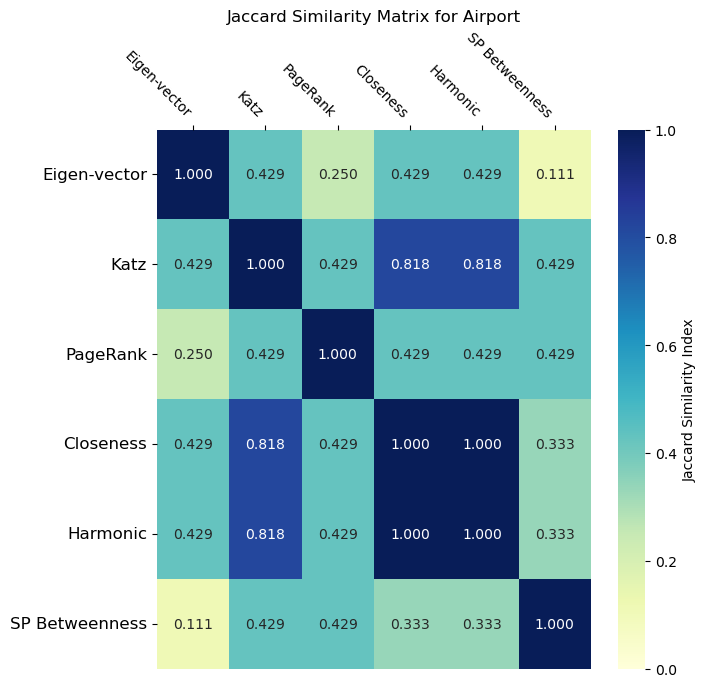

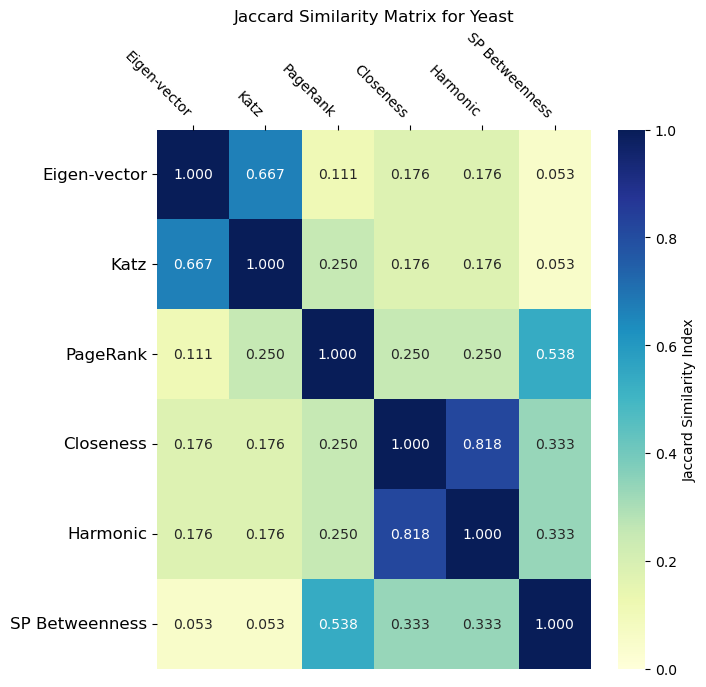

In [5]:
# Load the networks
G_airport, G_yeast = load_graphs()

# Get the top nodes
top_airport_nodes = top_10_nodes(G_airport)
top_yeast_nodes = top_10_nodes(G_yeast)

# Generate the similarity matrcies
node_similarity_airport = calculate_similarity_matrix(top_airport_nodes)
node_similarity_yeast = calculate_similarity_matrix(top_yeast_nodes)

# Generate the heatmaps
plot_similarity_heatmap(node_similarity_airport, 'Airport')
plot_similarity_heatmap(node_similarity_yeast, 'Yeast')


## Written Response for 1.4

Answer:

# Part 2: Community Detection with Zachary’s Karate Club [25 points]

### 2.1

In [6]:
def compute_cfinder_communities(G, k):
    """
    Inputs:
    G: NetworkX Graph Object
    k: Size of the clique for k-clique percolation method

    Returns:
    community_assignments: list[int]
    """
    communities = list(k_clique_communities(G, k))
    node_community_map = {}
    multiple_community_label = len(communities)  # 额外的标签，用于多社区节点

    for i, community in enumerate(communities):
        for node in community:
            if node in node_community_map:
                node_community_map[node] = multiple_community_label  # 归入特殊类别
            else:
                node_community_map[node] = i
    
    community_assignments = [node_community_map.get(node, -1) for node in G.nodes()]
    return community_assignments

def compute_greedy_communities(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    communities = list(greedy_modularity_communities(G))
    node_community_map = {}
    multiple_community_label = len(communities)

    for i, community in enumerate(communities):
        for node in community:
            if node in node_community_map:
                node_community_map[node] = multiple_community_label  # 归入多社区分类
            else:
                node_community_map[node] = i
    
    community_assignments = [node_community_map.get(node, -1) for node in G.nodes()]
    return community_assignments

def compute_louvain_communities(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    partition = community.best_partition(G)
    community_assignments = [partition.get(str(node), partition.get(int(node), -1)) for node in G.nodes()]
    return community_assignments

### 2.2

In [7]:
def plot_network_communities(G, community_assignments, algorithm_name, save=False):
    """
    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int]
    algorithm_name: str
    """
    random.seed(1)
    np.random.seed(1)

    # Get unique community labels
    communities = set(community_assignments)
    
    # Set a colormap with enough distinct colors
    color_map = plt.get_cmap("tab20", len(communities))
    community_colors = {community: color_map(i) for i, community in enumerate(communities)}

    # Handle nodes that were not assigned to any community
    if -1 not in community_colors:
        community_colors[-1] = 'black'  # 未分类的节点设为黑色
    
    # Assign node colors based on community
    node_colors = [community_colors[community] for community in community_assignments]
    
    # Create a layout for the graph
    pos = nx.spring_layout(G, seed=42)  # positions for all nodes
    
    plt.figure(figsize=(5, 5))
    
    # Draw the graph
    nx.draw(G, pos, node_size=300, with_labels=True, node_color=node_colors, 
            font_size=10, font_weight='bold', edge_color='gray')
    
    # Add a title
    plt.title(f'{algorithm_name} - Network Communities', fontsize=14)
    
    plt.show()
    if save:
        plt.savefig(f'karate_communities_{algorithm_name}.png')
    plt.close()


Graph density: 0.1390
k=3, critical density=0.171499
Graph is very sparse, using default k=3


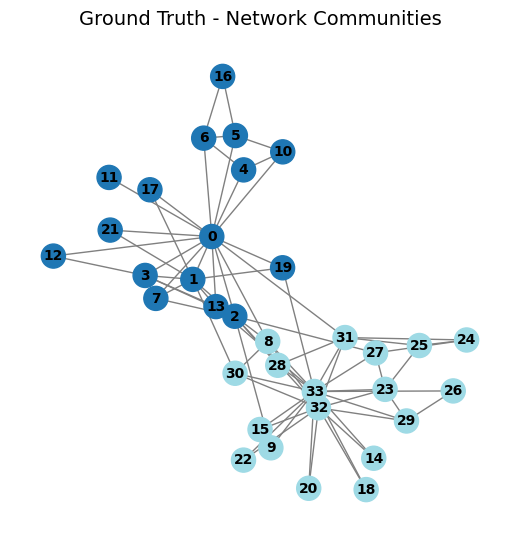

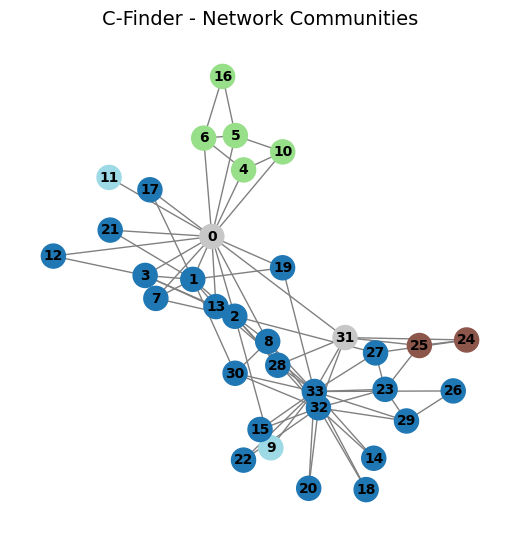

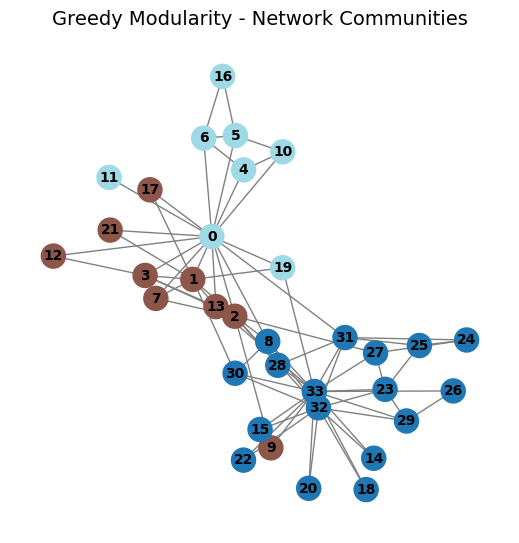

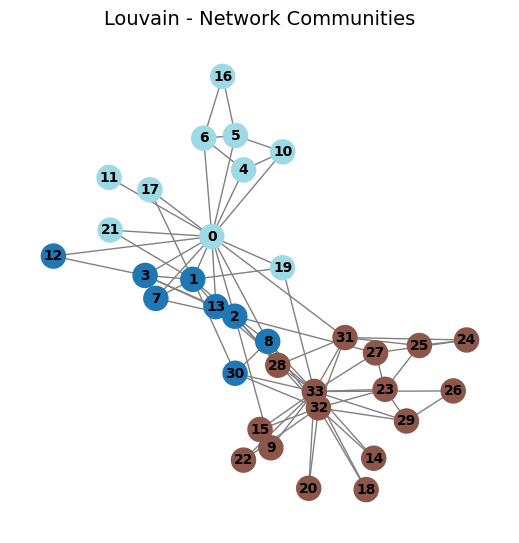

In [8]:
def select_k_for_cfinder(G):
    """
    Dynamically select a valid k for C-Finder based on graph density.
    """
    n = G.number_of_nodes()
    density = nx.density(G)

    print(f"Graph density: {density:.4f}")

    max_valid_k = None
    best_k = 3  # 设置默认 k 值

    
#k 值	社区结构匹配度	适用场景	最终评价
#k=5	过少，遗漏许多节点	适用于超密集网络	过大
#k=4	适中，但部分节点仍未分配	适用于稍密集的社区结构	还可以
#k=3	最佳匹配 Karate Club	适用于 Karate Club 这种网络	最优选择
#k=2	过度划分，社区太多	适用于超级稀疏图	过小

    # 计算不同 k 的临界密度
    for k in range(3, min(10, n // 5)):  # 限制最大 k 值，防止溢出
        p_critical = np.power(n, -1.0 / (k - 1))
        print(f"k={k}, critical density={p_critical:.6f}")

        if density > p_critical:
            max_valid_k = k  # 记录最大可行 k
        else:
            break  # 一旦临界密度超过图的密度，就停止

    if max_valid_k is not None:
        print(f"Recommended k={max_valid_k} (largest k where density > critical_density)")
        return max_valid_k
    else:
        print(f"Graph is very sparse, using default k={best_k}")
        return best_k

G = nx.karate_club_graph()

# 自动选择 k
k = select_k_for_cfinder(G)
ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]


# Chose a reasonable value for k in the cfinder algorithm 
cfinder_assignments = compute_cfinder_communities(G, k) ##自动选择k
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)


# Compare resulting community assignments with the ground truth
plot_network_communities(G, ground_truth, 'Ground Truth')
plot_network_communities(G, cfinder_assignments, 'C-Finder')
plot_network_communities(G, greedy_assignments, 'Greedy Modularity')
plot_network_communities(G, louvain_assignments, 'Louvain')


## Written Response for 2.3

Answer:

# Part 3: Community Detection with LFR Networks [25 points]

### 3.1

In [9]:
# Generating the LFR Benchmark Network
def generate_lfr_benchmark(mu):
    """
    Inputs:
    mu: float

    Returns:
    G: NetworkX Graph Object
    community_assignments: list[int]
    """
    
    n = 500
    tau1 = 2.5
    tau2 = 2
    min_degree = 3
    min_community = 40
    seed = 10
    
    # Ensure `mu` is within the valid range (0.1, 0.9) to avoid extreme values
    mu = max(0.1, min(1.0, mu))

    # Generate the LFR benchmark graph
    G = nx.LFR_benchmark_graph(
        n, tau1=tau1, tau2=tau2, mu=mu,
        min_degree=min_degree,
        min_community=min_community,
        seed=seed
    )

    # Convert community sets to unique community IDs
    node_to_community = {}
    community_id = 0

    for node in G.nodes():
        for comm in G.nodes[node]['community']:
            if comm not in node_to_community:
                node_to_community[comm] = community_id
                community_id += 1
        # 确保社区列表不为空
        if G.nodes[node]['community']:
            G.nodes[node]['community'] = node_to_community[next(iter(G.nodes[node]['community']))]
        else:
            G.nodes[node]['community'] = -1  # 没有社区时，赋值为 -1

    # Extract community assignments
    community_assignments = [G.nodes[node]['community'] for node in G.nodes]
    


    return G, community_assignments


### 3.2

In [10]:
def normalized_mutual_information(y_true, y_pred):
    """
    Inputs:
    y_true: list[int]
    y_pred: list[int]

    Returns:
    NMI: float
    """
    # 计算熵 H(U) 和 H(V)
    def entropy(labels):
        label_counts = Counter(labels)
        total = len(labels)
        return -sum((count / total) * np.log2(count / total) for count in label_counts.values())

    # 计算互信息 I(U, V)
    true_counts = Counter(y_true)
    pred_counts = Counter(y_pred)
    total = len(y_true)
    
    joint_counts = Counter(zip(y_true, y_pred))
    mi = sum(
        (count / total) * np.log2((count / total) / (true_counts[u] / total * pred_counts[v] / total))
        for (u, v), count in joint_counts.items()
    )

    # 计算 NMI
    H_true = entropy(y_true)
    H_pred = entropy(y_pred)

    NMI = 2 * mi / (H_true + H_pred) if (H_true + H_pred) > 0 else 0.0
    return NMI

### 3.3

In [11]:
def sweep_mu_values():
    """
    
    Returns:
    greedy_nmis: list[float]
    louvain_nmis: list[float]
    
    """
    greedy_nmis = []
    louvain_nmis = []

    # 确保 mu 值与 A3 需求一致（10 个点，0.1 到 1.0）
    mu_values = np.linspace(0.1, 1.0, 10)

    for mu in mu_values:
        try:
            # 生成 LFR 真实社区
            G, ground_truth = generate_lfr_benchmark(mu)

            # 处理空 ground_truth 的情况， 看看要不要删除
            if not ground_truth:
                print(f"Warning: Empty community labels for mu={mu}")
                greedy_nmis.append(np.nan)
                louvain_nmis.append(np.nan)
                continue

            # 计算 Greedy 社区
            greedy_assignments = compute_greedy_communities(G)
            greedy_assignments = [c if c != -1 else 0 for c in greedy_assignments]  # ✅ 避免 -1 影响 NMI
            greedy_nmi = normalized_mutual_information(ground_truth, greedy_assignments)
            greedy_nmis.append(greedy_nmi)

            # 计算 Louvain 社区
            louvain_assignments = compute_louvain_communities(G)
            louvain_assignments = [c if c != -1 else 0 for c in louvain_assignments]  # ✅ 避免 -1 影响 NMI
            louvain_nmi = normalized_mutual_information(ground_truth, louvain_assignments)
            louvain_nmis.append(louvain_nmi)

        except Exception as e:
            print(f"Error processing mu={mu}: {e}")
            greedy_nmis.append(np.nan)  # 避免数据结构出错
            louvain_nmis.append(np.nan)
            continue



    return greedy_nmis, louvain_nmis

### 3.4

In [12]:
def plot_nmi_values(greedy_nmis, louvain_nmis, save=False):
    """
    Inputs:
    greedy_nmis: list[int]
    louvain_nmis: list[int]
    """
    # **确保 `mu_values` 生成 10 个点，与 `sweep_mu_values()` 一致**
    mu_values = np.linspace(0.1, 1.0, 10)

    if len(greedy_nmis) != len(mu_values) or len(louvain_nmis) != len(mu_values):
        print(f"Error: The length of greedy_nmis ({len(greedy_nmis)}) or louvain_nmis ({len(louvain_nmis)}) does not match mu_values ({len(mu_values)}).")
        return

    greedy_nmis = np.array(greedy_nmis)
    louvain_nmis = np.array(louvain_nmis)
    mu_values = np.array(mu_values)

    # Identify NaN values
    greedy_nan_mask = np.isnan(greedy_nmis)
    louvain_nan_mask = np.isnan(louvain_nmis)

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot Greedy Modularity NMI values
    plt.plot(mu_values, greedy_nmis, label='Greedy Modularity', marker='o', linestyle='-', color='b')

    # Mark NaN points for Greedy
    if np.any(greedy_nan_mask):
        plt.scatter(mu_values[greedy_nan_mask], greedy_nmis[greedy_nan_mask], color='gray', marker='o', label='Greedy (Failed)')

    # Plot Louvain NMI values
    plt.plot(mu_values, louvain_nmis, label='Louvain', marker='x', linestyle='--', color='r')

    # Mark NaN points for Louvain
    if np.any(louvain_nan_mask):
        plt.scatter(mu_values[louvain_nan_mask], louvain_nmis[louvain_nan_mask], color='gray', marker='x', label='Louvain (Failed)')

    # Add labels and title
    plt.xlabel('Mu (Mixing Parameter)', fontsize=12)
    plt.ylabel('Normalized Mutual Information (NMI)', fontsize=12)
    plt.title('NMI Comparison: Greedy Modularity vs Louvain', fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=10)

    plt.show()
    
    if save:
        plt.savefig('3_4.png')
    plt.close()

### 3.5

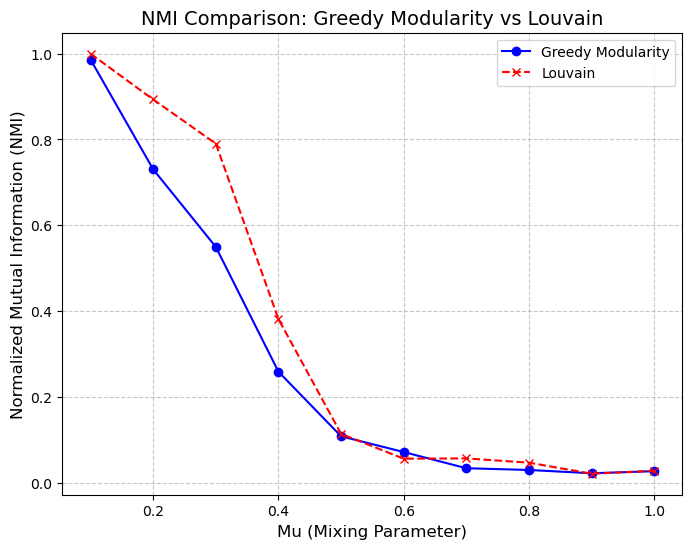

In [13]:
greedy_nmis, louvain_nmis = sweep_mu_values()

plot_nmi_values(greedy_nmis, louvain_nmis)

## Written Response for 3.5

Answer:

# Part 4: Community Detection on Real World Data [15 points]

### 4.1

In [14]:
def calculate_community_sizes(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns: 
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    """
    # Greedy Modularity Communities
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_sizes = [len(community) for community in greedy_communities]

    # Ensure the graph is undirected for Louvain
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()

    # Louvain Communities
    G_louvain = G.copy()
    partition = community.best_partition(G_louvain)

    # Convert partition dictionary to list of communities
    community_dict = {}
    for node, comm in partition.items():
        community_dict.setdefault(comm, set()).add(node)
    louvain_comms = list(community_dict.values())

    louvain_sizes = [len(community) for community in louvain_comms]


    return greedy_sizes, louvain_sizes

### 4.2

In [24]:
def plot_community_size_distributions(greedy_sizes, louvain_sizes, data_name, save=False):
    """
    Inputs:
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    data_name: str
    """

    # Count frequency of each community size
    greedy_unique, greedy_counts = np.unique(greedy_sizes, return_counts=True)
    louvain_unique, louvain_counts = np.unique(louvain_sizes, return_counts=True)
    
    plt.figure(figsize=(8,6))
    
    # Plot scatter points for Greedy Modularity community sizes
    plt.scatter(greedy_unique, greedy_counts, color='b', label='Greedy Modularity', alpha=0.6)
    
    # Plot scatter points for Louvain community sizes
    plt.scatter(louvain_unique, louvain_counts, color='r', label='Louvain', alpha=0.6)
    
    # Adjust x-axis limits to avoid excessive empty space
    plt.xlim(1, max(max(greedy_sizes), max(louvain_sizes)) * 1.1)
    plt.yscale("log")  # Log scale for better visualization of distributions
    plt.xscale("log")
    
    # Add labels and title
    plt.xlabel('Community Size (log scale)', fontsize=12)
    plt.ylabel('Frequency (log scale)', fontsize=12)
    plt.title(f'Community Size Distributions: {data_name}', fontsize=14)
    
    # Add a legend
    plt.legend()
    
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    

    plt.show()
    
    if save:
        plt.savefig('4_2.png')
    plt.close()

# After tried Histogram, violin and scatter plot, I found scatter can display the community size and disctrbutions in those.

### 4.3

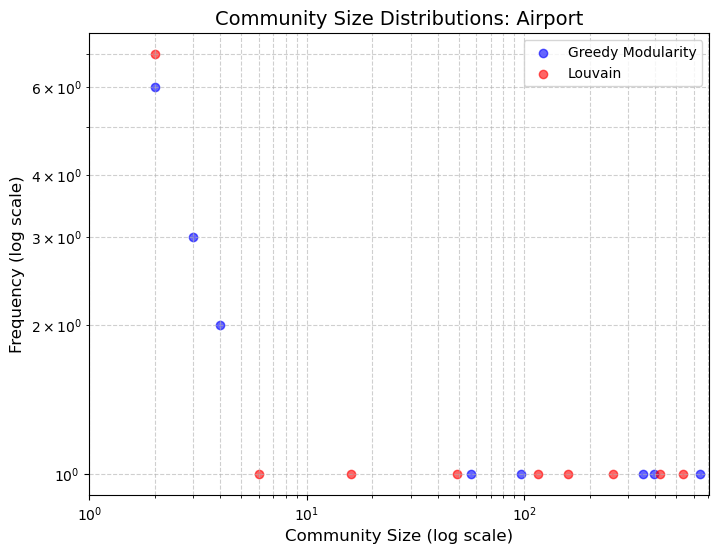

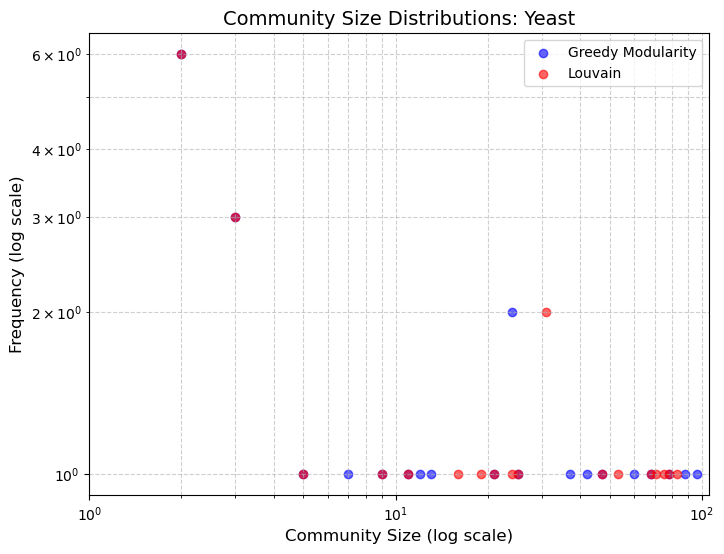

In [25]:
G_airport, G_yeast = load_graphs()

# Airport
greedy_sizes, louvain_sizes = calculate_community_sizes(G_airport)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Airport')

# Yeast
greedy_sizes, louvain_sizes = calculate_community_sizes(G_yeast)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Yeast')

## Written Response for 4.3

Answer:

In [18]:
def compute_modularity(G, community_assignments):
    """
    Compute the modularity score Q for a given partition.

    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int] - List of community indices for each node.

    Returns:
    Q: float - Modularity score.
    """
    # 转换 community_assignments 为 NetworkX 需要的格式
    community_dict = {}
    for node, comm in enumerate(community_assignments):
        if comm not in community_dict:
            community_dict[comm] = []
        community_dict[comm].append(node)
    
    # 转换为 NetworkX 格式的社区列表
    communities = list(community_dict.values())


    # 计算模块度
    Q = modularity(G, communities)
    return Q

In [19]:
# 先正确生成 G 和 Ground Truth
G, ground_truth_assignments = generate_lfr_benchmark(mu=0.5)

# 确保所有的 community_assignments 变量都已定义
cfinder_assignments = compute_cfinder_communities(G, k=3)  # 你可能需要调整 k 值
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)

# 计算 Partition 1-4 的模块度
Q_ground_truth = compute_modularity(G, ground_truth_assignments)
Q_cfinder = compute_modularity(G, cfinder_assignments)
Q_greedy = compute_modularity(G, greedy_assignments)
Q_louvain = compute_modularity(G, louvain_assignments)

# 打印模块度值
print(f"Ground Truth Modularity: {Q_ground_truth:.4f}")
print(f"C-Finder Modularity: {Q_cfinder:.4f}")
print(f"Greedy Modularity: {Q_greedy:.4f}")
print(f"Louvain Modularity: {Q_louvain:.4f}")


Ground Truth Modularity: 0.2601
C-Finder Modularity: 0.0538
Greedy Modularity: 0.3193
Louvain Modularity: 0.3221


## Response for 5



### Partition 1:

Image:

Modularity:

### Partition 2:

Image:

Modularity:

### Partition 3:

Image:

Modularity:

### Partition 4:

Image:

Modularity: